# Continuously-observed: no event types

Let $\mathbb{Y} = \{ X(t_i) \}_{i}$ be observed data. The total birth rate from state $k$ is the sum of PW and HO rates 

$$
\lambda_{k}(\beta_1, \beta_2) = \beta_1 S_{k}^{(1)} + \beta_2 S_{k}^{(2)} = a_{k}(\beta_1) + b_{k}(\beta_2)
$$


## Definitions

In [1]:
def sk1(k, N):
    r""" Calculates structural count $S_{k}^{(1)}$ for CSC. """
    if k <= 0 or k >= N:
        return 0
    return k * (N - k)

def sk2(k, N):
    r""" Calculates structural count $S_{k}^{(2)}$ for CSC. """
    if k < 2 or k >= N:
        return 0
    return 0.5 * k * (k - 1) * (N - k)

def lambda_k(k, N, beta1, beta2):
    r""" Calculates birth rate from state k for CSC. """
    return beta1 * sk1(k, N) + beta2 * sk2(k, N)

In [2]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from simulate_gillespie import gillespie_sim_complete

## Setup

In [3]:
N = 1000
I0 = 10
time_max = 10.0
mu_true = 1.0

# true parameters for data generation 
# Case 1: "Balanced"
# beta1_true, beta2_true = (2.4, 4.4)

# Case 2: low PW, high HO
# beta1_true, beta2_true = (1.4, 8.0)

# Case 3: high PW, low HO
# beta1_true, beta2_true = (3.7, 1.0)

# hard problem:
beta1_true, beta2_true = (1.8, 1)

# convert SCALED true betas to ORIGINAL per-interaction true betas
beta1_orig_true = beta1_true / N
beta2_orig_true = beta2_true / (N**2)

## Generate data

In [4]:
nsims = 1 # NOTE: single run
# TODO: try with 10, or even 100 runs

X_sims = []
for _ in range(nsims):
    X_t = gillespie_sim_complete(N, beta1_orig_true, beta2_orig_true, mu_true, I0, time_max)
    X_sims.append(X_t)

Plot saved to ../figures/inference/no_event_data.pdf


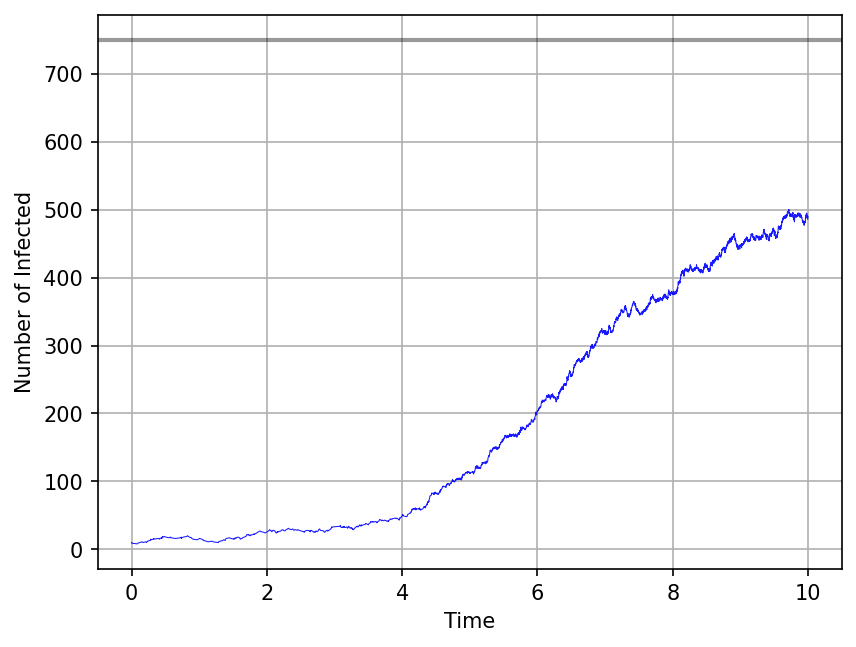

In [5]:
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()
ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)
plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)

output_filename = "../figures/inference/no_event_data.pdf"
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to {output_filename}")

plt.show()

In [6]:
# X_t = [t, waiting_time, total_infected, event_type, total_pw_count, total_ho_count]

## Sufficient (aggregated) statistics

- $B_k$: Total number of observed births from state $k$.
- $D_k$: Total number of observed deaths from state $k$.
- $T_k$: Total time spent in state $k$.

In [7]:
def get_sufficient_stats(trajectory, N):
    r"""
    Calculates the sufficient statistics: `T_k, B_k, D_k` from a single run (trajectory):
        - trajectory[0, :] are event times
        - trajectory[2, :] are states (total infected)
    """
    times = trajectory[0]
    states = trajectory[2].astype(int)

    T_k = np.zeros(N + 1)
    B_k = np.zeros(N + 1)
    D_k = np.zeros(N + 1)

    for i in range(len(times) - 1):
        current_k = states[i]
        
        time_spent = times[i + 1] - times[i]
        T_k[current_k] += time_spent

        # Determine the event at the end of the interval
        next_k = states[i+1]
        if next_k > current_k:
            # then it was a birth event from current_k state
            B_k[current_k] += 1
        elif next_k < current_k:
            # it was a death event from current_k state
            D_k[current_k] += 1
        # else: it is the final record at time_max not an event
        
    return {'T_k': T_k, 'B_k': B_k, 'D_k': D_k}

In [8]:
stats = get_sufficient_stats(X_t, N)

In [9]:
print(f"Total time spent in states:")
visited_k = np.where(stats['T_k'] > 0)[0]
for k in visited_k[:5]:
    print(f"  k={k}: T_k = {stats['T_k'][k]:.4f}")

print(f"\nTotal births from states:")
birth_k = np.where(stats['B_k'] > 0)[0]
for k in birth_k[:5]:
    print(f"  k={k}: B_k = {int(stats['B_k'][k])}")

print(f"\nTotal deaths from states:")
death_k = np.where(stats['D_k'] > 0)[0]
for k in death_k[:5]:
    print(f"  k={k}: D_k = {int(stats['D_k'][k])}")

Total time spent in states:
  k=8: T_k = 0.0073
  k=9: T_k = 0.1093
  k=10: T_k = 0.0838
  k=11: T_k = 0.2041
  k=12: T_k = 0.1125

Total births from states:
  k=8: B_k = 1
  k=9: B_k = 1
  k=10: B_k = 4
  k=11: B_k = 3
  k=12: B_k = 2

Total deaths from states:
  k=9: D_k = 1
  k=10: D_k = 1
  k=11: D_k = 3
  k=12: D_k = 2
  k=13: D_k = 1


## Likelihood 

$$
\ell(\beta_1, \beta_2) = \sum_{k = 0}^{N} \left[ B_k \ln(\lambda_k(\beta_1, \beta_2)) + D_k \ln(\mu_k(\mu)) - (\lambda_k(\beta_1, \beta_2) + \mu_k(\mu)) T_k \right]
$$

Create grid and plot the likelihood surface:

In [10]:
def calculate_log_likelihood(params, stats, N, mu):
    r"""
    Calculates the log-likelihood for continuously observed data without event types.
    """
    beta1, beta2 = params
    T_k, B_k, D_k = stats['T_k'], stats['B_k'], stats['D_k']
    
    logL = 0
    for k in range(N + 1):
        if T_k[k] > 0: # only states that were visited
            lambda_val = lambda_k(k, N, beta1, beta2)
            mu_val = mu * k
            # birth term
            if B_k[k] > 0:
                if lambda_val > 1e-12: # avoid log(0)
                    logL += B_k[k] * np.log(lambda_val)
                else: # zero rate: probability is zero
                    return -np.inf 
            
            # TODO: death term is not needed here
            if D_k[k] > 0:
                if mu_val > 1e-12:
                    logL += D_k[k] * np.log(mu_val)
                else:
                    return -np.inf
            
            # waiting time term
            logL -= (lambda_val + mu_val) * T_k[k]
            
    return logL

In [11]:
def compute_likelihood_surface(b1_range, b2_range, stats, N, mu):
    r"""
    Computes the log-likelihood over a grid of scaled beta parameters
    given:
      - b1_range: (min, max, steps) for scaled beta1
      - b2_range: (min, max, steps) for scaled beta2
      - stats: observed (sufficient) statistics T_k, B_k, D_k
    """
    beta1_vec = np.linspace(*b1_range)
    beta2_vec = np.linspace(*b2_range)
    
    logL_surface = np.zeros((b1_range[2], b2_range[2]))

    for i, b1 in enumerate(beta1_vec):
        for j, b2 in enumerate(beta2_vec):
            b1_orig = b1 / N
            b2_orig = b2 / (N**2)
            logL_surface[i, j] = calculate_log_likelihood(
                [b1_orig, b2_orig], stats, N, mu
            )
    # transpose for plotting (X = beta1, Y = beta2)
    logL_surface = logL_surface.T
    
    return {
        "beta1_scaled_vec": beta1_vec,
        "beta2_scaled_vec": beta2_vec,
        "logL_surface": logL_surface
    }

## Plotting

In [15]:
def plot_zoomed_likelihood(surface_data, true_params, threshold=-5.0):
    r"""
    Zoomed-in contour plot of the log-likelihood surface.
    threshold defines the distance from max for the zoom-in region.
    """
    b1_vec = surface_data["beta1_scaled_vec"]
    b2_vec = surface_data["beta2_scaled_vec"]
    logL = surface_data["logL_surface"]
    
    b1_true, b2_true = true_params
    
    # determine grid MLE and high-likelihood region
    logL_max = np.nanmax(logL)
    max_loc = np.unravel_index(np.nanargmax(logL), logL.shape)
    mle_b2 = b2_vec[max_loc[0]]
    mle_b1 = b1_vec[max_loc[1]]
    
    # indices within the threshold of the max
    high_likelihood_indices = np.argwhere(logL >= logL_max + threshold)
    
    # zoom-in boundaries from the indices
    min_b2_idx, min_b1_idx = high_likelihood_indices.min(axis=0)
    max_b2_idx, max_b1_idx = high_likelihood_indices.max(axis=0)
    
    # padding to the boundaries
    padding_b1 = (b1_vec[1] - b1_vec[0]) * 2
    padding_b2 = (b2_vec[1] - b2_vec[0]) * 2
    
    xlim = (b1_vec[min_b1_idx] - padding_b1, b1_vec[max_b1_idx] + padding_b1)
    ylim = (b2_vec[min_b2_idx] - padding_b2, b2_vec[max_b2_idx] + padding_b2)

    # -------------------
    # --- Plotting ------
    # -------------------
    fig, ax = plt.subplots(figsize=(8, 6.5), dpi=150)
    
    # relative scale for colors
    relative_logL = logL - logL_max
    
    contour = ax.contourf(b1_vec, b2_vec, relative_logL,
                          levels=np.linspace(threshold, 0, 21),
                          cmap='viridis')

    ax.contour(b1_vec, b2_vec, relative_logL,
               levels=np.linspace(threshold, 0, 5), 
               colors='white', linewidths=0.5, alpha=0.7)

    # true values and grid MLE as red X and blue X
    ax.plot(b1_true, b2_true, 'rx', markersize=12, markeredgewidth=2.5, label='True Value')
    ax.plot(mle_b1, mle_b2, 'bx', markersize=12, markeredgewidth=2, label='Grid MLE')
    
    ax.set_xlabel(r'Scaled Pairwise Rate ($\beta_1 N$)', fontsize=14)
    ax.set_ylabel(r'Scaled Higher-Order Rate ($\beta_2 N^2$)', fontsize=14)
    
    # apply zoom-in
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.legend(fontsize=12)
    fig.colorbar(contour, label=r'$\ell(\beta_1, \beta_2) - \ell_{max}$')
    ax.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()

    output_filename = "../figures/inference/no_event_log_likelihood_contour.pdf"
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to {output_filename}")

    plt.show()

In [18]:
b1_range = (0, 6.0, 100)
b2_range = (0, 12.0, 100)
surface_data = compute_likelihood_surface(b1_range, b2_range, stats, N, mu_true)

Plot saved to ../figures/inference/no_event_log_likelihood_contour.pdf


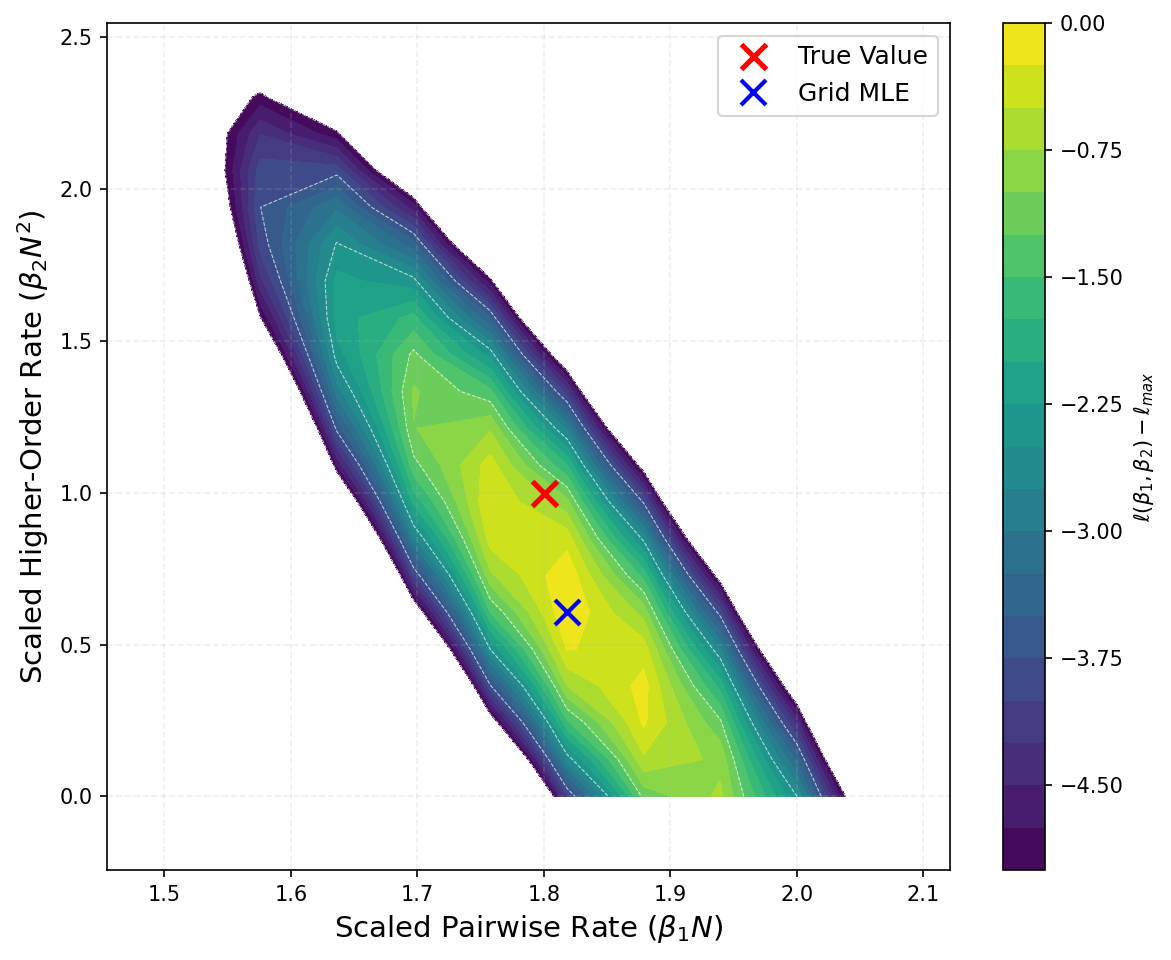

In [19]:
plot_zoomed_likelihood(surface_data, (beta1_true, beta2_true), threshold=-5.0)